# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import sklearn.manifold as sm

# Data Preperation

In [2]:
# reshape and map in [0, 1]
process = lambda d: tf.cast(tf.expand_dims(d, -1), tf.float32) / 255

# add noise to image
add_noise = lambda d: d + .33 * tf.random.normal(mean=0.0, stddev=1.0, shape=d.shape)

def prepare_data(data):
    
    # apply functions
    data = data.map(lambda d1, d2: (process(d1), process(d2)))
    data = data.map(lambda d1, d2: (add_noise(d1), d2))
    
    # shuffle, batch, prefetch
    data = data.cache()
    data = data.shuffle(500)
    data = data.batch(32)
    data = data.prefetch(5)
    return data

In [3]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_data))
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_data))

train_ds = train_ds.apply(prepare_data)
test_ds = test_ds.apply(prepare_data)

# Encoder

In [4]:
class Encoder(tf.keras.Model):
    
    def __init__(self, dim):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32, kernel_size=(3,3), strides=(2,2), padding='same',
            activation='relu'
        )
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64, kernel_size=(3,3), strides=(2,2), padding='same',
            activation='relu'
        )
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(3136, activation=tf.nn.relu)
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.out = tf.keras.layers.Dense(dim, activation=tf.nn.relu)
        
    @tf.function
    def call(self, inputs, training):
        x = self.conv1(inputs, training=training)
        x = self.batch1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x, training=training)
        x = self.batch2(x, training=training)
        x = tf.nn.relu(x)
        x = self.flatten(x, training=training)
        x = self.dense(x, training=training)
        x = self.batch3(x, training=training)
        x = tf.nn.relu(x)
        x = self.out(x, training=training)
        return x

# Decoder

In [5]:
class Decoder(tf.keras.Model):
    
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = tf.keras.layers.Dense(3136, activation=tf.nn.relu)
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.reshape = tf.keras.layers.Reshape((7,7,64))
        self.convTranspose1 = tf.keras.layers.Conv2DTranspose(
            filters=64, kernel_size=(3,3), strides=(2,2), padding='same', 
            activation='relu'
        )
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.convTranspose2 = tf.keras.layers.Conv2DTranspose(
            filters=32, kernel_size=(2,2), strides=(2,2), padding='same', 
            activation='relu'
        )
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.conv = tf.keras.layers.Conv2D(
            filters=1, kernel_size=(3,3), strides=(1,1), padding='same',
            activation='sigmoid'
        )
        
    @tf.function
    def call(self, inputs, training):
        x = self.dense1(inputs, training=training)
        x = self.batch1(x, training=training)
        x = tf.nn.relu(x)
        x = self.reshape(x, training=training)
        x = self.convTranspose1(x, training=training)
        x = self.batch2(x, training=training)
        x = tf.nn.relu(x)
        x = self.convTranspose2(x, training=training)
        x = self.batch3(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv(x, training=training)
        return x

# Autoencoder

In [6]:
class Autoencoder(tf.keras.Model):
    
    def __init__(self, dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(dim)
        self.decoder = Decoder()
        
    @tf.function
    def call(self, inputs, training):
        encoded = self.encoder(inputs, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

# Training Utils

In [7]:
def train_step(model, input, target, loss_function, optimizer, training=True):
# loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input, training=training)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def test(model, test_data, loss_function):
# test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input, training=False)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy


def train(model, train_ds, test_ds, num_epochs, optimizer, loss_fn):
    tf.keras.backend.clear_session()
    
    # Initialize lists for later visualization.
    train_losses = []

    test_losses = []
    test_accuracies = []

    #testing once before we begin
    test_loss, test_accuracy = test(model, test_ds, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #check how model performs on train data once before we begin
    train_loss, _ = test(model, train_ds, loss_fn)
    train_losses.append(train_loss)

    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

        #training (and checking in with training)
        epoch_loss_agg = []
        for input,target in train_ds:
            train_loss = train_step(model, input, target, loss_fn, optimizer)
            epoch_loss_agg.append(train_loss)

        #track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        #testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_ds, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    return train_losses, test_losses, test_accuracies


def visualize_training(train_losses, test_losses, test_accuracies):
    # Visualize accuracy and loss for training and test data.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    line3, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1,line2, line3),("training", "test", "test accuracy"))
    plt.show()

# Training

In [8]:
def train_model(model):

    ### Hyperparameters
    num_epochs = 10
    learning_rate = 0.001

    # Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
    mse_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO, name='mean_squared_error')
    # Initialize the optimizer: Adam. Check out 'tf.keras.optimizers'
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    with tf.device('/device:gpu:0'):
        hist = train(model=model, train_ds=train_ds, test_ds=test_ds, num_epochs=num_epochs, optimizer=optimizer, loss_fn=mse_loss)

    visualize_training(*hist)

Epoch: 0 starting with accuracy 0.020695458694659972
Epoch: 1 starting with accuracy 0.13244166476494754
Epoch: 2 starting with accuracy 0.17578659858512088
Epoch: 3 starting with accuracy 0.19120835235052488
Epoch: 4 starting with accuracy 0.17250613304427198
Epoch: 5 starting with accuracy 0.18049691921497032
Epoch: 6 starting with accuracy 0.18610223642172524
Epoch: 7 starting with accuracy 0.1946350125513464
Epoch: 8 starting with accuracy 0.19451377795527156
Epoch: 9 starting with accuracy 0.17973385440438155


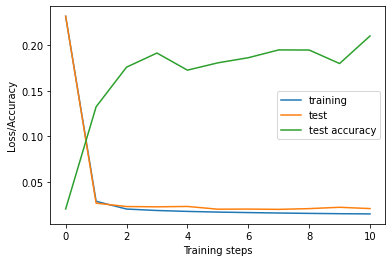

In [9]:
autoencoder_10 = Autoencoder(10)
train_model(autoencoder_10)

# Latent Space

In [10]:
data = process(test_data[:1000])
labels = test_labels[:1000]
out = autoencoder_10.encoder(data)
tsne = sm.TSNE(n_components=2).fit_transform(out)

C:\Users\Dominik\.conda\envs\iannwtf\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dominik\.conda\envs\iannwtf\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


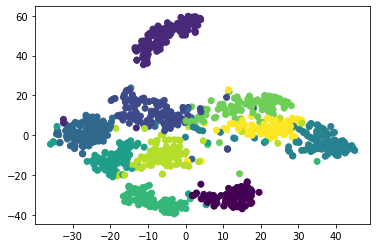

In [11]:
plot = plt.scatter(tsne[:,0], tsne[:,1], c=labels)

The different digits build clusters that are mostly seperat from each other.

# Interpolation

In [12]:
ipn = autoencoder_10.decoder(tf.convert_to_tensor([out[0] * f * .1 + out[2] * (10 - f) * .1 for f in range(10)]))

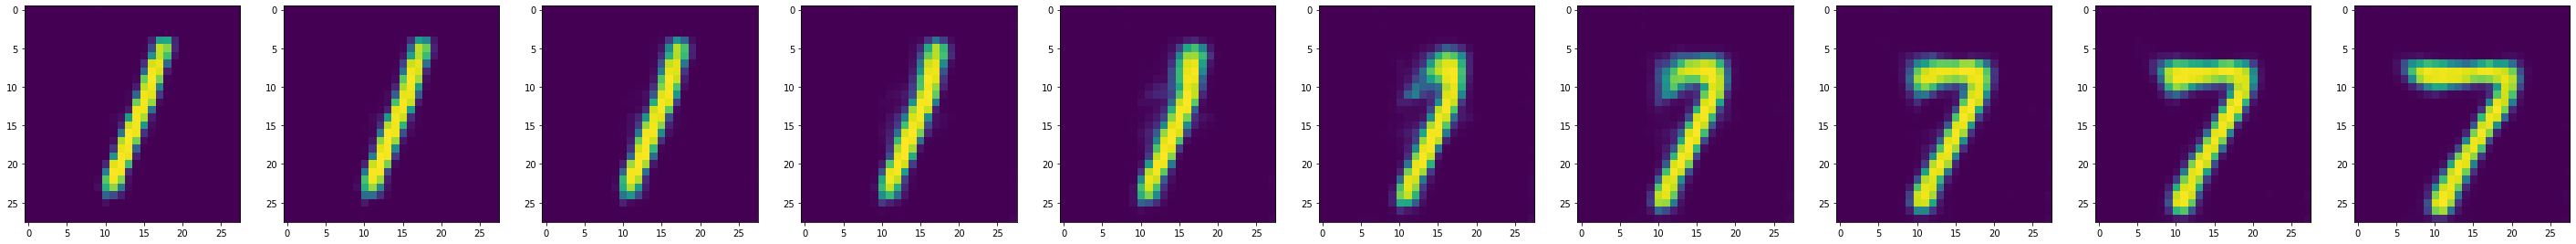

In [13]:
plt.figure(figsize=(50, 20))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(ipn[i])